# Diabetes Dataset - Binary Classification Notebook with 5 Models

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load and convert regression target to binary classification
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = (diabetes.target > 140).astype(int)  # 1 if disease progression is high, else 0
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,0


Class Distribution (Proportion):
target
1    0.5
0    0.5
Name: proportion, dtype: float64


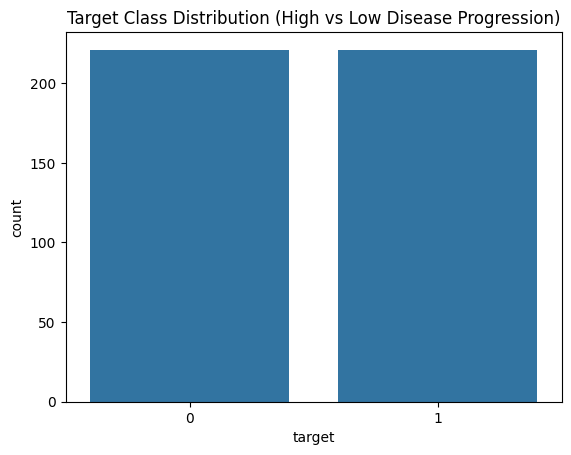

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,0.500000
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,0.500567
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,0.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,0.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,0.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,1.000000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,1.000000


In [2]:

print("Class Distribution (Proportion):")
print(df['target'].value_counts(normalize=True))

sns.countplot(x='target', data=df)
plt.title("Target Class Distribution (High vs Low Disease Progression)")
plt.show()

df.describe()


In [3]:

X = df.drop("target", axis=1)
y = df["target"]

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, X.columns.tolist())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [4]:

models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        {'clf__C': [0.1]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'clf__n_estimators': [100], 'clf__max_depth': [None]}
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(),
        {'clf__n_estimators': [100]}
    ),
    'SVC': (
        SVC(probability=True, class_weight='balanced'),
        {'clf__C': [1]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [5]}
    )
}


In [5]:

results = []

for model_name, (model, param_grid) in models.items():
    print(f"Training: {model_name}")
    start = time.time()

    pipe = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    grid = GridSearchCV(pipe, param_grid, cv=2, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((model_name, grid.best_params_, acc, prec, rec, f1, auc))

    print(f"Time: {time.time() - start:.2f} sec")
    print("Best Params:", grid.best_params_)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("ROC AUC:", auc)
    print()


Training: Logistic Regression


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Lib

Time: 2.71 sec
Best Params: {'clf__C': 0.1}
Accuracy: 0.7303370786516854
Precision: 0.7083333333333334
Recall: 0.7727272727272727
F1 Score: 0.7391304347826086
ROC AUC: 0.8318181818181818

Training: Random Forest


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Time: 2.01 sec
Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Accuracy: 0.7640449438202247
Precision: 0.7254901960784313
Recall: 0.8409090909090909
F1 Score: 0.7789473684210526
ROC AUC: 0.8247474747474747

Training: Gradient Boosting


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Time: 2.08 sec
Best Params: {'clf__n_estimators': 100}
Accuracy: 0.7078651685393258
Precision: 0.6875
Recall: 0.75
F1 Score: 0.717391304347826
ROC AUC: 0.7838383838383839

Training: SVC


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Time: 1.42 sec
Best Params: {'clf__C': 1}
Accuracy: 0.7415730337078652
Precision: 0.7142857142857143
Recall: 0.7954545454545454
F1 Score: 0.7526881720430108
ROC AUC: 0.8257575757575757

Training: KNN
Time: 0.09 sec
Best Params: {'clf__n_neighbors': 5}
Accuracy: 0.7528089887640449
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
ROC AUC: 0.8388888888888889



/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Lib

In [6]:

results_df = pd.DataFrame(results, columns=[
    'Model', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'
])
results_df.sort_values("F1 Score", ascending=False)


,Model,Best Params,Accuracy,Precision,Recall,F1 Score,ROC AUC
1,Random Forest,"{'clf__max_depth': None, 'clf__n_estimators': ...",0.764045,0.725490,0.840909,0.778947,0.824747
3,SVC,{'clf__C': 1},0.741573,0.714286,0.795455,0.752688,0.825758
4,KNN,{'clf__n_neighbors': 5},0.752809,0.750000,0.750000,0.750000,0.838889
0,Logistic Regression,{'clf__C': 0.1},0.730337,0.708333,0.772727,0.739130,0.831818
2,Gradient Boosting,{'clf__n_estimators': 100},0.707865,0.687500,0.750000,0.717391,0.783838
